In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder,LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_curve, roc_auc_score
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from matplotlib import pyplot
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [20]:
data = pd.read_csv('preprocessed_data.csv')

In [21]:
print(data.head(10))

   uniqueID                          drugName                     condition  \
0    206461                         valsartan  left ventricular dysfunction   
1     95260                        guanfacine                          adhd   
2     92703                            lybrel                 birth control   
3    138000                        ortho evra                 birth control   
4     35696            buprenorphine naloxone             opiate dependence   
5    155963                            cialis  benign prostatic hyperplasia   
6    165907                    levonorgestrel       emergency contraception   
7    102654                      aripiprazole               bipolar disorde   
8     74811                            keppra                      epilepsy   
9     48928  ethinyl estradiol levonorgestrel                 birth control   

                                              review  usefulCount  Rating  \
0  side effect take combination bystolic 5 mg fis... 

In [22]:
print(data.shape)

(159498, 9)


In [23]:
print(data['Rating'].value_counts())

1    112003
0     47495
Name: Rating, dtype: int64


In [24]:
print(data.head(2))

   uniqueID    drugName                     condition  \
0    206461   valsartan  left ventricular dysfunction   
1     95260  guanfacine                          adhd   

                                              review  usefulCount  Rating  \
0  side effect take combination bystolic 5 mg fis...           27       1   
1  son halfway fourth week intuniv became concern...          192       1   

   year  month  day  
0  2012      5   20  
1  2010      4   27  


In [25]:
x = data.drop(['Rating'],axis=1)
y = data['Rating']

<p> Splitting the dataset into training and test datasets </p>

In [33]:
X_train, X_test, Y_train, Y_test = train_test_split(x,y,test_size=0.20,random_state=42)

In [34]:
print(X_train.shape,X_test.shape)

(127598, 8) (31900, 8)


In [28]:
!pip install imblearn

In [35]:
from imblearn.over_sampling import RandomOverSampler
over_sampler = RandomOverSampler(random_state=42)
X_train, y_train = over_sampler.fit_resample(X_train, Y_train)

In [38]:
from collections import Counter
print(f"Training target statistics: {Counter(y_train)}")

Training target statistics: Counter({1: 89545, 0: 89545})


<p> uniqueId column </p>

In [39]:
scaler_unique = StandardScaler()
scaler_unique.fit(X_train['uniqueID'].values.reshape(-1,1))
train_unique = scaler_unique.transform(X_train['uniqueID'].values.reshape(-1,1))
test_unique = scaler_unique.transform(X_test['uniqueID'].values.reshape(-1,1))
train_unique.shape

(179090, 1)

In [40]:
scaler_usefulCount = StandardScaler()
scaler_usefulCount.fit(X_train['usefulCount'].values.reshape(-1,1))
train_usefulCount = scaler_unique.transform(X_train['usefulCount'].values.reshape(-1,1))
test_usefulCount = scaler_unique.transform(X_test['usefulCount'].values.reshape(-1,1))
train_usefulCount.shape

(179090, 1)

In [41]:
scaler_year = StandardScaler()
scaler_year.fit(X_train['year'].values.reshape(-1,1))
train_year = scaler_unique.transform(X_train['year'].values.reshape(-1,1))
test_year = scaler_unique.transform(X_test['year'].values.reshape(-1,1))
train_year.shape

(179090, 1)

In [42]:
scaler_month = StandardScaler()
scaler_month.fit(X_train['month'].values.reshape(-1,1))
train_month = scaler_unique.transform(X_train['month'].values.reshape(-1,1))
test_month = scaler_unique.transform(X_test['month'].values.reshape(-1,1))

In [43]:
scaler_day = StandardScaler()
scaler_day.fit(X_train['day'].values.reshape(-1,1))
train_day = scaler_unique.transform(X_train['day'].values.reshape(-1,1))
test_day = scaler_unique.transform(X_test['day'].values.reshape(-1,1))

In [44]:
def onehoten(featuretrain,featuretest):
    labelencoder = LabelEncoder()
    #training
    train_lab = labelencoder.fit_transform(featuretrain)
    train_int_lab_sub = train_lab.reshape(len(train_lab),1)
    #test
    test_lab = labelencoder.fit_transform(featuretest)
    test_int_lab_sub = test_lab.reshape(len(test_lab),1)
    onehot_encoder = OneHotEncoder(sparse=False)
    onehot_encoder.fit(train_int_lab_sub)
    train_feature = onehot_encoder.transform(train_int_lab_sub)
    test_feature = onehot_encoder.transform(test_int_lab_sub)
    transformed = [train_feature,test_feature]
    return transformed

In [45]:
train_drugName,test_drugName = onehoten(X_train['drugName'],X_test['drugName'])

In [46]:
print(train_drugName.shape)
print(test_drugName.shape)

(179090, 3228)
(31900, 3228)


In [47]:
train_condition,test_condition = onehoten(X_train['condition'],X_test['condition'])

In [48]:
print(train_condition.shape)
print(test_condition.shape)

(179090, 785)
(31900, 785)


In [49]:
import pickle
vectorizer = TfidfVectorizer()
vectorizer.fit(X_train['review'].values.astype('U'))
with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

In [50]:
train_review = vectorizer.transform(X_train['review'].values.astype('U'))
test_review = vectorizer.transform(x_test['review'].values.astype('U'))

In [51]:
model = LogisticRegression()
space = dict()

space['penalty'] = ['l1', 'l2']
space['C'] = loguniform(1e-5, 10)
cv = 3

In [31]:
search = RandomizedSearchCV(model, space, n_iter=100, scoring='accuracy', n_jobs=-1, cv=cv, random_state=1)

In [34]:
result = search.fit(train_review, y_train)

print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: 0.8415335532547368
Best Hyperparameters: {'C': 3.9386206724436077, 'penalty': 'l2'}


In [35]:
model = LogisticRegression(C=3.9386206724436077,penalty= 'l2')
model.fit(train_review, y_train)

LogisticRegression(C=3.9386206724436077)

In [58]:
y_pred = model.predict(test_review)
print(y_pred.shape)

(31900,)


Test confusion matrix


Text(33.0, 0.5, 'Actual label')

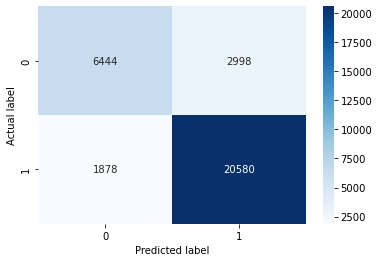

In [59]:
print("Test confusion matrix")

cntestlog = confusion_matrix(Y_test,y_pred)
sns.heatmap(cntestlog, annot=True,fmt="d",cmap='Blues')

plt.xlabel("Predicted label")
plt.ylabel("Actual label")

In [60]:
#Accuracy of the model
Accuracy = (cntestlog[0][0] + cntestlog[1][1]) / (cntestlog[0][0] + cntestlog[1][1] + cntestlog[0][1] + cntestlog[1][0])
print("Accuracy log test",Accuracy)

Accuracy log test 0.8471473354231975


Train confusion matrix


Text(33.0, 0.5, 'Actual label')

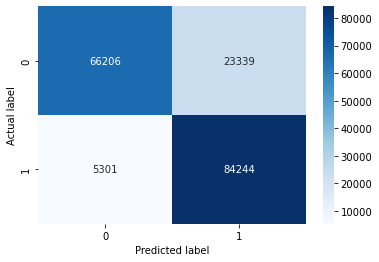

In [61]:
ytrainpred = model.predict(train_review)
print("Train confusion matrix")
#plot confusion matrix
cnlogtrain = confusion_matrix(y_train,ytrainpred)
sns.heatmap(cnlogtrain, annot=True,fmt="d",cmap='Blues')

plt.xlabel("Predicted label")
plt.ylabel("Actual label")

In [62]:
Accuracy = (cnlogtrain[0][0] + cnlogtrain[1][1]) / (cnlogtrain[0][0] + cnlogtrain[1][1] + cnlogtrain[0][1] + cnlogtrain[1][0])
print("Accuracy log train",Accuracy)

Accuracy log train 0.8400804064995254


roc auc score = 0.9035570533517163


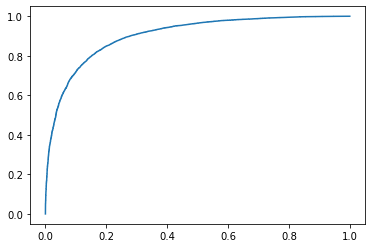

In [63]:
y_pred_proba = model.predict_proba(test_review)[:, 1]
print(f"roc auc score = {roc_auc_score(y_test, y_pred_proba)}")
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.plot(fpr, tpr)

<ul> Observations:
    <li> Accuracy = 84% </li>
    <li> AUC = 0.90 </li>

# Decision Tree 

In [52]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
model = DecisionTreeClassifier()
# parameters dict
params = {
    'max_depth' : [1, 3, 10, 30,45],
    'min_samples_split' : [5, 10, 100, 500,1000],
    "min_samples_leaf": [1,3,4,5,6,7],
    "criterion": ["gini", "entropy"]
}
#Randomsearch
clf = RandomizedSearchCV(model,params,cv=3,scoring='roc_auc',return_train_score=True)
clf.fit(train_review,y_train)



max_depth = clf.cv_results_['param_max_depth']
#best parameter
best_para = clf.best_params_
print(best_para)

{'min_samples_split': 10, 'min_samples_leaf': 5, 'max_depth': 45, 'criterion': 'gini'}


In [53]:
min_sample = clf.best_params_['min_samples_split']
min_sample =  clf.best_params_['min_samples_split']
max_depth = clf.best_params_['max_depth']
criter =  clf.best_params_['criterion']

Test confusion matrix


Text(33.0, 0.5, 'Actual label')

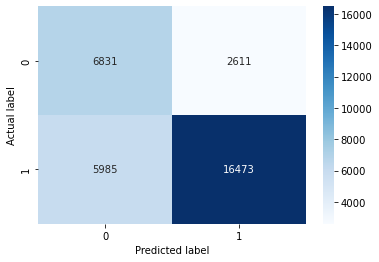

In [61]:
#training model with best parameters found using randomsearch
clfnewd = DecisionTreeClassifier(min_samples_split = min_sample,min_samples_leaf=min_sample,max_depth=max_depth,criterion=criter)
clfnewd.fit(train_review,y_train)
#Presicting values for test samples
ydpred = clfnewd.predict(test_review)
print("Test confusion matrix")
#Plot confusion matrix
cn2 = confusion_matrix(Y_test,ydpred)
sns.heatmap(cn2, annot=True,fmt="d",cmap='Blues')

plt.xlabel("Predicted label")
plt.ylabel("Actual label")

In [62]:
#Accuracy of model test
Accuracy = (cn2[0][0] + cn2[1][1]) / (cn2[0][0] + cn2[1][1] + cn2[0][1] + cn2[1][0])
print("Accuracy",Accuracy)

Accuracy 0.7305329153605016


Train confusion matrix


Text(33.0, 0.5, 'Actual label')

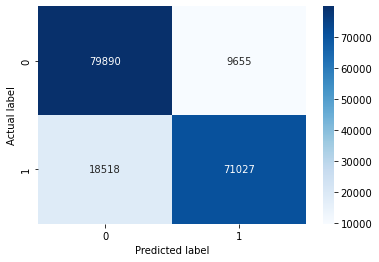

In [63]:
ytrainpred = clfnewd.predict(train_review)
print("Train confusion matrix")
#Plot confusion matrix for Train samples
cn3 = confusion_matrix(y_train,ytrainpred)
sns.heatmap(cn3, annot=True,fmt="d",cmap='Blues')

plt.xlabel("Predicted label")
plt.ylabel("Actual label")

In [64]:
#Accuracy of model train
Accuracy = (cn3[0][0] + cn3[1][1]) / (cn3[0][0] + cn3[1][1] + cn3[0][1] + cn3[1][0])
print("Accuracy",Accuracy)

Accuracy 0.8426880339494109


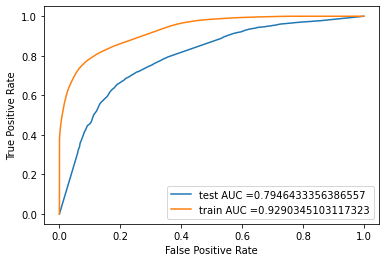

In [71]:
#computing prob. of getting the target variable to compute the AUC score
y_train_proba = clfnewd.predict_proba(train_review)[::,1]
y_proba_pred = clfnewd.predict_proba(test_review)[::,1]
fpr, tpr, _ = metrics.roc_curve(Y_test,  y_proba_pred)
fprtrain,tprtrain,_ = metrics.roc_curve(y_train,y_train_proba)
#create ROC curve
plt.plot(fpr,tpr,label="test AUC ="+str(auc(fpr,tpr)))
plt.plot(fprtrain,tprtrain,label="train AUC ="+str(auc(fprtrain,tprtrain)))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

<ul> Observations:
    <li> Accuracy = 73% </li>
    <li> AUC = 0.794 </li>

<h2> Naive Bayes Classifier </h2>

In [73]:
from sklearn.naive_bayes import MultinomialNB

Test confusion matrix


Text(33.0, 0.5, 'Actual label')

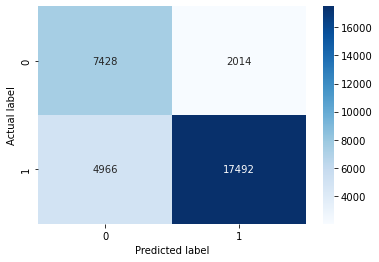

In [78]:
clfnewd = MultinomialNB()
clfnewd.fit(train_review,y_train)
#Presicting values for test samples
ydpred = clfnewd.predict(test_review)
print("Test confusion matrix")
#Plot confusion matrix
cn2 = confusion_matrix(Y_test,ydpred)
sns.heatmap(cn2, annot=True,fmt="d",cmap='Blues')

plt.xlabel("Predicted label")
plt.ylabel("Actual label")

In [80]:
#Accuracy of the model
Accuracy = (cn2[0][0] + cn2[1][1]) / (cn2[0][0] + cn2[1][1] + cn2[0][1] + cn2[1][0])
print("Accuracy test",Accuracy)

Accuracy test 0.7811912225705329


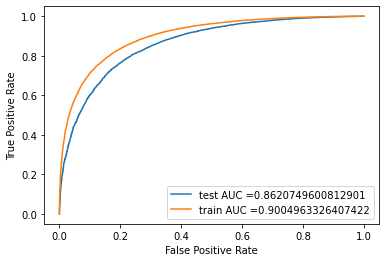

In [81]:
#computing prob. of getting the target variable to compute the AUC score
y_train_proba = clfnewd.predict_proba(train_review)[::,1]
y_proba_pred = clfnewd.predict_proba(test_review)[::,1]
fpr, tpr, _ = metrics.roc_curve(Y_test,  y_proba_pred)
fprtrain,tprtrain,_ = metrics.roc_curve(y_train,y_train_proba)
#create ROC curve
plt.plot(fpr,tpr,label="test AUC ="+str(auc(fpr,tpr)))
plt.plot(fprtrain,tprtrain,label="train AUC ="+str(auc(fprtrain,tprtrain)))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

<ul> Observations:
    <li> Accuracy = 78% </li>
    <li> AUC = 0.86 </li>

<h2> Random Forest</h2>

In [85]:
from sklearn.ensemble import RandomForestClassifier
parameters = {
    'n_estimators'      : [330,340,500],
    'max_depth'         : [8,11, 12,18],
    'criterion'         : ['gini', 'log_loss'],
    'max_leaf_nodes'    : [6,2,4,5]
    
}
model = RandomForestClassifier()
#Randomsearch
clfrandom = RandomizedSearchCV(model,parameters,cv=3,scoring='roc_auc',return_train_score=True)
clfrandom.fit(train_review,y_train)

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(),
                   param_distributions={'criterion': ['gini', 'log_loss'],
                                        'max_depth': [8, 11, 12, 18],
                                        'max_leaf_nodes': [6, 2, 4, 5],
                                        'n_estimators': [330, 340, 500]},
                   return_train_score=True, scoring='roc_auc')

In [86]:
n_estimator = clfrandom.best_params_['n_estimators']
max_depth = clfrandom.best_params_['max_depth'] 
criterion = clfrandom.best_params_['criterion'] 
max_leaf_nodes = clfrandom.best_params_['max_leaf_nodes'] 

In [87]:
#training the model using best parameters
modelrandom = RandomForestClassifier(n_estimators=n_estimator,max_depth=max_depth,criterion=criterion,max_leaf_nodes=max_leaf_nodes)
modelrandom.fit(train_review,y_train)

RandomForestClassifier(max_depth=11, max_leaf_nodes=5, n_estimators=340)

Test confusion matrix


Text(33.0, 0.5, 'Actual label')

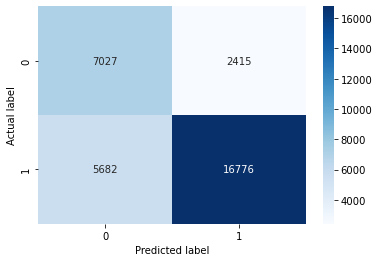

In [89]:
#Presicting values for test samples
ydpred = modelrandom.predict(test_review)
print("Test confusion matrix")
#Plot confusion matrix
cnr = confusion_matrix(Y_test,ydpred)
sns.heatmap(cn2, annot=True,fmt="d",cmap='Blues')

plt.xlabel("Predicted label")
plt.ylabel("Actual label")

In [90]:
#Accuracy of the model
Accuracy = (cnr[0][0] + cnr[1][1]) / (cnr[0][0] + cnr[1][1] + cnr[0][1] + cnr[1][0])
print("Accuracy test",Accuracy)

Accuracy test 0.7461755485893417


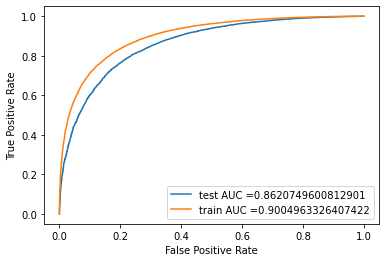

In [92]:
#computing prob. of getting the target variable to compute the AUC score
y_train_proba = clfnewd.predict_proba(train_review)[::,1]
y_proba_pred = clfnewd.predict_proba(test_review)[::,1]
fpr, tpr, _ = metrics.roc_curve(Y_test,  y_proba_pred)
fprtrain,tprtrain,_ = metrics.roc_curve(y_train,y_train_proba)
#create ROC curve
plt.plot(fpr,tpr,label="test AUC ="+str(auc(fpr,tpr)))
plt.plot(fprtrain,tprtrain,label="train AUC ="+str(auc(fprtrain,tprtrain)))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

<ul> Observations:
    <li> Accuracy = 74% </li>
    <li> AUC = 0.86 </li>

<h2> For Deployment </h2>

In [96]:
filename = 'finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))
 


In [2]:
import flask
print(flask.__version__)

1.1.2


In [6]:
print(python.__version__)

NameError: name 'python' is not defined

In [7]:
import sys
print(sys.version)


3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]
